In [1732]:
import pyxdf
import mne
import numpy as np
# streams, header = pyxdf.load_xdf("sub-P005/ses-S001/eeg/sub-P005_ses-S001_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder
streams, header = pyxdf.load_xdf("18maypbao\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg.xdf")
# streams, header = pyxdf.load_xdf("18maypbao\sub-P001\ses-S002\eeg\sub-P001_ses-S002_task-Default_run-001_eeg.xdf")



Stream 2: Calculated effective sampling rate 784.2982 Hz is different from specified rate 250.0000 Hz.


In [1733]:
streams[2]

{'info': defaultdict(list,
             {'name': ['obci_eeg3'],
              'type': ['EEG'],
              'channel_count': ['125'],
              'nominal_srate': ['250'],
              'channel_format': ['float32'],
              'source_id': ['openbcigui'],
              'version': ['1.1000000000000001'],
              'created_at': ['101148.4772216'],
              'uid': ['5d847615-0cd4-4d88-8b23-1c8416c20fc7'],
              'session_id': ['default'],
              'hostname': ['DesktopFifa'],
              'v4address': [None],
              'v4data_port': ['16574'],
              'v4service_port': ['16574'],
              'v6address': [None],
              'v6data_port': ['16574'],
              'v6service_port': ['16574'],
              'desc': [None],
              'stream_id': 2,
              'effective_srate': 784.2981940582713}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['101370.4473356'],
               'last_timestamp': ['101671.9827895']

In [1734]:
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data

In [1735]:
raw_data.shape

(8, 75450)

In [1736]:
# channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
# info = mne.create_info(
#     ch_names= channels,
#     ch_types= ['eeg']*len(channels),
#     sfreq= 250 #OpenBCI Frequency acquistion
# )
# # Create MNE rawarray
# raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

In [1737]:
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

In [1738]:
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [1739]:
raw_mne_dropped = raw_mne.drop_channels(ch_names=['CH7','CH8'],on_missing='raise')

In [1740]:
raw_mne_dropped

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [1741]:
s = 3

In [1742]:
event_index = streams[s]["time_series"].T[0] #Get all event marker of experiment 
event_timestamp = streams[s]["time_stamps"].T #Timestamp when event marked

In [1743]:
event_index

array([ 5,  0,  1,  2,  3,  4,  5,  0,  1,  2,  3,  4,  5,  0,  1,  2,  3,
        4,  5,  0,  1,  2,  3,  4,  5,  0,  1,  2,  3,  4,  5, -1,  0])

In [1744]:
streams[s]["time_stamps"][0]

101373.24617148504

In [1745]:
event_timestamp = [0]
for i in range(1,len(streams[s]["time_series"])):
    event_timestamp.append( int(streams[s]["time_stamps"][i])-int(streams[s]["time_stamps"][0]))
event_timestamp
event_timestamp = np.array(event_timestamp)
event_timestamp = event_timestamp.T
print(type(event_timestamp))

<class 'numpy.ndarray'>


In [1746]:
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

In [1747]:
raw_mne_dropped[0]

(array([[14695.57910156, 14770.79296875, 15507.99804688, ...,
         15323.328125  , 15291.96875   , 15340.15820312]]),
 array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 3.01788e+02,
        3.01792e+02, 3.01796e+02]))

In [1748]:
events

array([[  0,   0,   5],
       [  0,   0,   0],
       [ 10,   0,   1],
       [ 20,   0,   2],
       [ 30,   0,   3],
       [ 40,   0,   4],
       [ 50,   0,   5],
       [ 60,   0,   0],
       [ 70,   0,   1],
       [ 80,   0,   2],
       [ 90,   0,   3],
       [100,   0,   4],
       [110,   0,   5],
       [120,   0,   0],
       [130,   0,   1],
       [140,   0,   2],
       [150,   0,   3],
       [160,   0,   4],
       [170,   0,   5],
       [180,   0,   0],
       [190,   0,   1],
       [200,   0,   2],
       [210,   0,   3],
       [220,   0,   4],
       [230,   0,   5],
       [240,   0,   0],
       [250,   0,   1],
       [260,   0,   2],
       [270,   0,   3],
       [280,   0,   4],
       [290,   0,   5],
       [295,   0,  -1],
       [296,   0,   0]])

In [1749]:
events_id = { # Set up your event name
    'reset' : -1,
   'baseline' : 0,
   'forward': 1,
   'left': 2,
   'right': 3,
   'backward': 4,
   'break': 5
}


mne_epochs = mne.Epochs(raw_mne_dropped, events, 
        tmin= 0.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 15.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
     #    reject= dict(eeg = 40e-6),
     #    flat= dict(eeg = 1e-6),
        preload = True,
        baseline = (0.0,0.5),
        event_repeated='drop'
        
        
    )



Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 3751 original time points ...
0 bad epochs dropped


In [1750]:
mne_epochs

Number of events,32
Events,backward: 5baseline: 5break: 6forward: 5left: 5reset: 1right: 5
Time range,0.000 – 15.000 s
Baseline,0.000 – 0.500 s


In [1751]:
dropped_log = mne_epochs.plot_drop_log

In [1752]:
dropped_log

<bound method BaseEpochs.plot_drop_log of <Epochs |  32 events (all good), 0 – 15 s, baseline 0 – 0.5 s, ~5.5 MB, data loaded,
 'reset': 1
 'baseline': 5
 'forward': 5
 'left': 5
 'right': 5
 'backward': 5
 'break': 6>>

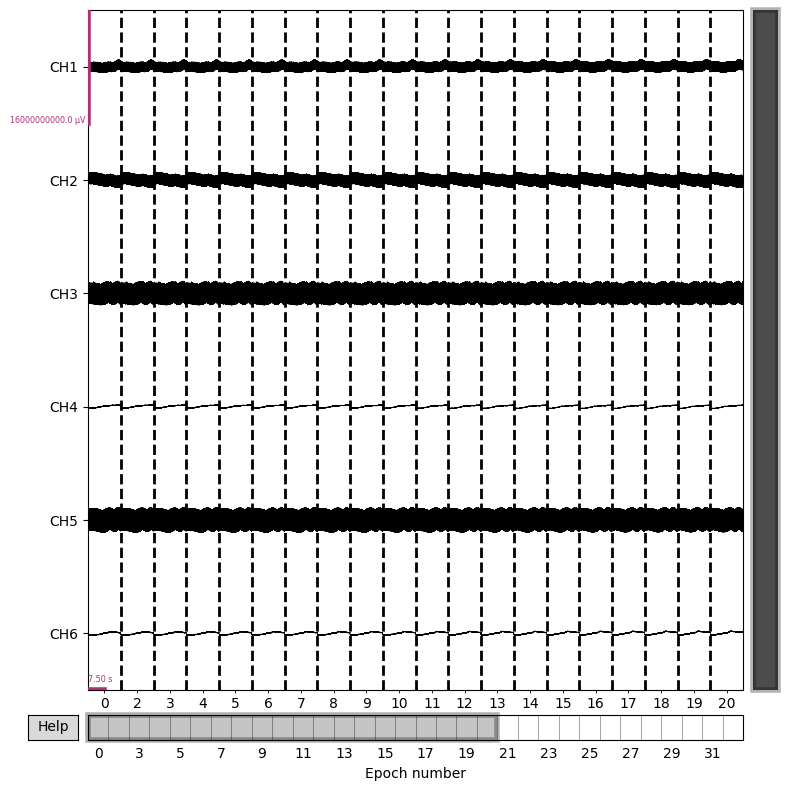

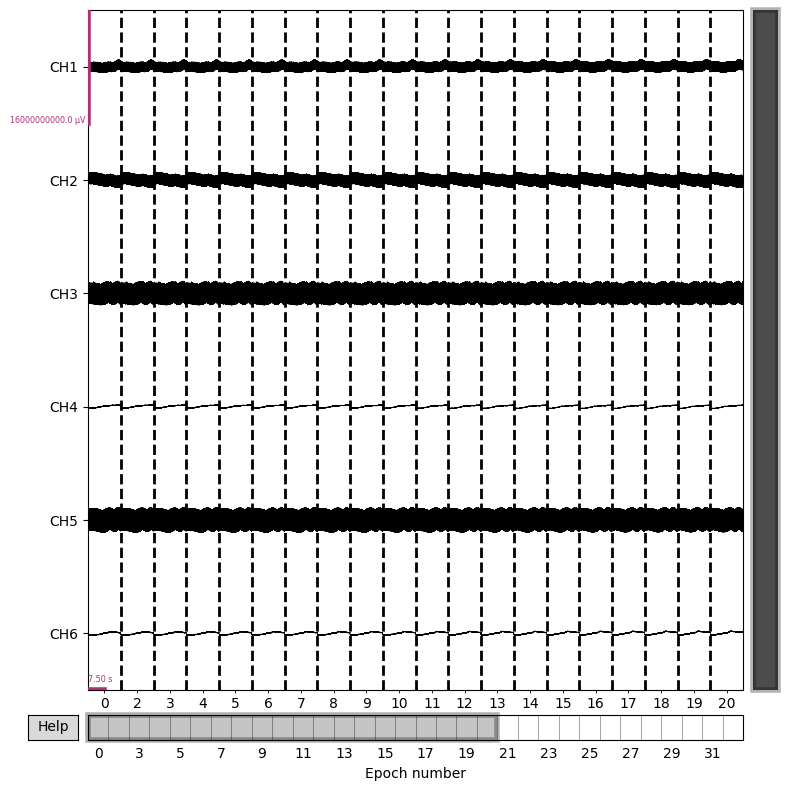

In [1753]:
mne_epochs.plot(scalings = 8000)


Setting up band-pass filter from 6 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 6.00, 18.00 Hz: -6.02, -6.02 dB



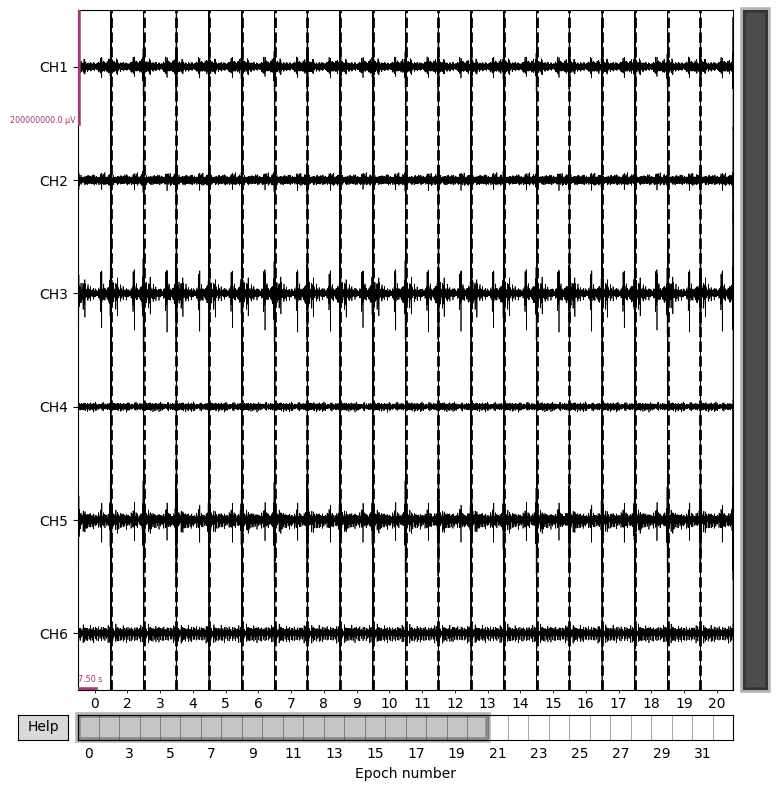

...


In [1754]:
mne_epochs.filter(l_freq=6.0, h_freq=18.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}).plot(scalings = 100)
print('...')

In [1755]:
print(mne_epochs.get_data().shape)
mne_epochs.get_data()

(32, 6, 3751)


C:\Users\papin\AppData\Local\Temp\ipykernel_5356\23489598.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(mne_epochs.get_data().shape)
C:\Users\papin\AppData\Local\Temp\ipykernel_5356\23489598.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  mne_epochs.get_data()


array([[[-2.73563852e-02,  1.22293497e+02,  2.32261588e+02, ...,
         -2.34748752e+02, -1.23670901e+02, -9.00308016e-03],
        [ 5.86787108e-02, -7.36485985e+01, -1.39766473e+02, ...,
          1.74422398e+02,  9.19361217e+01, -3.81070001e-03],
        [-7.07400737e-02,  2.37569070e+02,  4.51152234e+02, ...,
         -4.78691871e+02, -2.52195802e+02, -7.98882818e-03],
        [-1.02754886e-03, -4.10294123e+00, -7.67891718e+00, ...,
          6.02221033e+00,  3.13373306e+00, -5.06799172e-03],
        [-5.45457675e-02,  2.94765772e+02,  5.59643631e+02, ...,
         -5.60167845e+02, -2.95111893e+02, -4.95180964e-03],
        [-1.26444101e-03, -7.07468002e+00, -1.31928294e+01, ...,
          9.19791669e+00,  4.84491839e+00, -5.49033305e-03]],

       [[-2.82513125e-02,  1.22477284e+02,  2.32318713e+02, ...,
         -2.34945965e+02, -1.23775025e+02,  7.52575720e-03],
        [ 5.58226269e-02, -7.15425783e+01, -1.35966620e+02, ...,
          1.70460301e+02,  8.98286606e+01,  2.83088

In [1756]:
mne_df = mne_epochs.to_data_frame()
mne_df


,time,condition,epoch,CH1,CH2,CH3,CH4,CH5,CH6
0,0.000,break,0,-2.735639e+04,5.867871e+04,-7.074007e+04,-1.027549e+03,-5.454577e+04,-1.264441e+03
1,0.004,break,0,1.222935e+08,-7.364860e+07,2.375691e+08,-4.102941e+06,2.947658e+08,-7.074680e+06
2,0.008,break,0,2.322616e+08,-1.397665e+08,4.511522e+08,-7.678917e+06,5.596436e+08,-1.319283e+07
3,0.012,break,0,3.191750e+08,-1.917224e+08,6.198380e+08,-1.028106e+07,7.686437e+08,-1.754479e+07
4,0.016,break,0,3.753716e+08,-2.248183e+08,7.287084e+08,-1.160466e+07,9.032100e+08,-1.958484e+07
...,...,...,...,...,...,...,...,...,...
120027,14.984,baseline,32,-4.302434e+08,5.190942e+08,-9.942024e+08,4.560202e+06,-9.873039e+08,3.431214e+05
120028,14.988,baseline,32,-3.662090e+08,4.421892e+08,-8.466036e+08,3.696939e+06,-8.405735e+08,1.652239e+05
120029,14.992,baseline,32,-2.666741e+08,3.221622e+08,-6.166664e+08,2.598839e+06,-6.121978e+08,5.734982e+04
120030,14.996,baseline,32,-1.404807e+08,1.697594e+08,-3.249007e+08,1.339587e+06,-3.225232e+08,9.967130e+03


In [1757]:
mne_df

,time,condition,epoch,CH1,CH2,CH3,CH4,CH5,CH6
0,0.000,break,0,-2.735639e+04,5.867871e+04,-7.074007e+04,-1.027549e+03,-5.454577e+04,-1.264441e+03
1,0.004,break,0,1.222935e+08,-7.364860e+07,2.375691e+08,-4.102941e+06,2.947658e+08,-7.074680e+06
2,0.008,break,0,2.322616e+08,-1.397665e+08,4.511522e+08,-7.678917e+06,5.596436e+08,-1.319283e+07
3,0.012,break,0,3.191750e+08,-1.917224e+08,6.198380e+08,-1.028106e+07,7.686437e+08,-1.754479e+07
4,0.016,break,0,3.753716e+08,-2.248183e+08,7.287084e+08,-1.160466e+07,9.032100e+08,-1.958484e+07
...,...,...,...,...,...,...,...,...,...
120027,14.984,baseline,32,-4.302434e+08,5.190942e+08,-9.942024e+08,4.560202e+06,-9.873039e+08,3.431214e+05
120028,14.988,baseline,32,-3.662090e+08,4.421892e+08,-8.466036e+08,3.696939e+06,-8.405735e+08,1.652239e+05
120029,14.992,baseline,32,-2.666741e+08,3.221622e+08,-6.166664e+08,2.598839e+06,-6.121978e+08,5.734982e+04
120030,14.996,baseline,32,-1.404807e+08,1.697594e+08,-3.249007e+08,1.339587e+06,-3.225232e+08,9.967130e+03


In [1758]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.activations import tanh, elu, relu
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger


import os
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py

import os

In [1759]:
mne_df.describe()

,time,epoch,CH1,CH2,CH3,CH4,CH5,CH6
count,120032.0000,120032.000000,1.200320e+05,1.200320e+05,1.200320e+05,1.200320e+05,1.200320e+05,1.200320e+05
mean,7.5000,16.468750,6.742164e+04,-8.727277e+04,1.431523e+05,-2.704387e+02,1.633383e+05,9.234582e+02
std,4.3313,9.287074,2.171636e+07,1.355569e+07,4.231696e+07,2.611263e+06,5.179785e+07,4.239340e+06
min,0.0000,0.000000,-4.545204e+08,-5.406133e+08,-1.049586e+09,-2.357133e+07,-1.042575e+09,-3.123770e+07
25%,3.7480,8.750000,-2.800812e+06,-2.263920e+06,-3.107147e+06,-1.578451e+06,-2.725552e+06,-2.154336e+06
50%,7.5000,16.500000,5.570843e+04,5.796965e+04,-2.488122e+04,-3.396610e+03,3.845157e+04,1.017535e+05
75%,11.2520,24.250000,2.840691e+06,2.320918e+06,3.315863e+06,1.663580e+06,2.876537e+06,2.229863e+06
max,15.0000,32.000000,4.011099e+08,5.476939e+08,8.739678e+08,1.998077e+07,9.667115e+08,3.446206e+07


In [1760]:
from sklearn.preprocessing import StandardScaler
# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the data
channels = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6']
mne_df[channels] = scaler.fit_transform(mne_df[channels])

In [1761]:
i+=1
name = f'model{i}'

os.makedirs('models/'+ name)
with open('models/'+ name +'/training_log.csv', 'w') as file:
    pass

In [1762]:
batch_size = 64
test_size = 0.2
epochs = 64
input_size = 250

learning_rate = 0.001 
conv1d_strides = 3 #4
conv1d_filters = 36 #32
hidden_units = 32

In [1763]:
from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Concatenate, Reshape
from keras.layers import Conv1D, LSTM, Dropout
from keras.regularizers import l2

clear_session()
model = Sequential()
model.add(Conv1D(conv1d_filters, 12, strides=conv1d_strides, activation='relu', padding='same', input_shape=(input_size, 6)))
model.add(Conv1D(conv1d_filters, 12, strides=conv1d_strides, activation='relu', padding='same'))
model.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.0, kernel_regularizer=l2(0.001)))
model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.001)))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 84, 36)            2628      
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 36)            15588     
                                                                 
 lstm (LSTM)                 (None, 32)                8832      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 27,213
Trainable params: 27,213
Non-trainable params: 0
_________________________________________________________________
None


In [1764]:
mne_df['condition'].unique()

array(['break', 'forward', 'left', 'right', 'backward', 'baseline',
       'reset'], dtype=object)

In [1765]:
mne_df = mne_df[mne_df.condition != 'reset']
mne_df = mne_df[mne_df.condition != 'break']


In [1766]:
mne_df  = mne_df.replace('baseline', 'Idle')
mne_df  = mne_df.replace('break', 'Idle')

In [1767]:
# Prepare the input and output
X = mne_df[['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6']].values
y = mne_df['condition'].values

In [1768]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [1769]:
from scipy.signal import welch
def compute_psd(chunk):
    psd_features = []
    for i in range(chunk.shape[1]):  # Iterate over each feature (column)
        f, Pxx = welch(chunk[:, i], fs=250, nperseg=chunk.shape[0])
        psd_features.append(Pxx)
    return np.array(psd_features).flatten()  # Flatten the PSD features

In [1770]:
# Label encoding for the condition column
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_categorical = to_categorical(y_encoded, num_classes=5)

y_ordered = y_categorical[input_size-1:] 

indices = np.arange(input_size) + np.arange(len(X) - input_size + 1)[:, np.newaxis]
X_ordered = X[indices]

X_with_psd = np.array([np.concatenate((chunk.flatten(), compute_psd(chunk))) for chunk in X_ordered])

shuffled_indices = np.random.permutation(len(X_with_psd)) 
X_random = X_ordered[shuffled_indices]
y_random = y_ordered[shuffled_indices]

In [1771]:
checkpoint = ModelCheckpoint(
                            filepath='models/'+name+'/checkpoint-epoch{epoch:02d}-loss{val_loss:.4f}.h5',
                            monitor='val_loss',
                            verbose=16,
                            save_best_only=False,
                            save_weights_only=False,
                            mode='auto',
                            save_freq='epoch',
                            period=16
                            )

csv_logger = CSVLogger('models/'+name+'/training_log.csv', append=True)

In [1772]:
# Train Model ###################################################
model.fit(X_random,y_random, epochs=epochs, batch_size=batch_size, validation_split=test_size, callbacks=[checkpoint, csv_logger])    

Epoch 1/64
1170/1170 [==============================] - 14s 11ms/step - loss: 1.6176 - accuracy: 0.2042 - val_loss: 1.6126 - val_accuracy: 0.1920
Epoch 2/64
1170/1170 [==============================] - 12s 10ms/step - loss: 1.6069 - accuracy: 0.2046 - val_loss: 1.6053 - val_accuracy: 0.1989
Epoch 3/64
1170/1170 [==============================] - 12s 10ms/step - loss: 1.6035 - accuracy: 0.2063 - val_loss: 1.6042 - val_accuracy: 0.2037
Epoch 4/64
1170/1170 [==============================] - 12s 10ms/step - loss: 1.6022 - accuracy: 0.2090 - val_loss: 1.6036 - val_accuracy: 0.1976
Epoch 5/64
1170/1170 [==============================] - 12s 11ms/step - loss: 1.6073 - accuracy: 0.2046 - val_loss: 1.5976 - val_accuracy: 0.2150
Epoch 6/64
1170/1170 [==============================] - 12s 11ms/step - loss: 1.5784 - accuracy: 0.2217 - val_loss: 1.5323 - val_accuracy: 0.2308
Epoch 7/64
1170/1170 [==============================] - 12s 10ms/step - loss: 1.5365 - accuracy: 0.2362 - val_loss: 1.5270 -

In [1788]:
model.save('models/'+name+'/'+name+'2.h5')

In [1789]:
y_test = y_encoded[input_size-1:] 
indices = np.arange(input_size) + np.arange(len(X)-input_size+1)[:,np.newaxis] 
X_test = tf.gather(X,indices) 

prediction = model.predict(X_test, batch_size=batch_size)

1462/1462 [==============================] - 4s 3ms/step


In [1804]:
prediction

array([[0.00410058, 0.00346727, 0.9815045 , 0.00136603, 0.00956156],
       [0.00400195, 0.0036158 , 0.9814928 , 0.00160999, 0.00927942],
       [0.00392469, 0.00378664, 0.98062193, 0.00193733, 0.00972944],
       ...,
       [0.64487505, 0.06771522, 0.05301425, 0.06279085, 0.17160465],
       [0.56876004, 0.06857967, 0.03505389, 0.07175186, 0.2558544 ],
       [0.39263722, 0.09432232, 0.07417941, 0.10544227, 0.3334187 ]],
      dtype=float32)

In [1805]:
one_hot_output = np.zeros_like(prediction)
one_hot_output[np.arange(len(prediction)), prediction.argmax(1)] = 1

print(one_hot_output)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [1806]:
label_encoder.inverse_transform([0,1])

array(['Idle', 'backward'], dtype=object)

In [1807]:
reversed_array = np.argmax(one_hot_output, axis=1)

In [1808]:
sum(reversed_array == 1)

3678

In [1809]:
y_pred = label_encoder.inverse_transform(reversed_array)

In [1810]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have your actual labels and predicted labels
actual_labels = y[len(y) - len(y_pred):]
predicted_labels = label_encoder.inverse_transform(reversed_array)

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='macro')

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.3303359493616748
Precision: 0.5693653380120968
Recall: 0.32985955832722497
F1-score: 0.31251293025602894
Confusion Matrix:
[[14637    80    69  2009  1960]
 [11543  3326    43  1917  1926]
 [11565    75  2793  1976  2097]
 [11599   121    57  5027  1951]
 [11512    76    71  1984  5112]]


In [1811]:
conf_matrix

array([[14637,    80,    69,  2009,  1960],
       [11543,  3326,    43,  1917,  1926],
       [11565,    75,  2793,  1976,  2097],
       [11599,   121,    57,  5027,  1951],
       [11512,    76,    71,  1984,  5112]], dtype=int64)

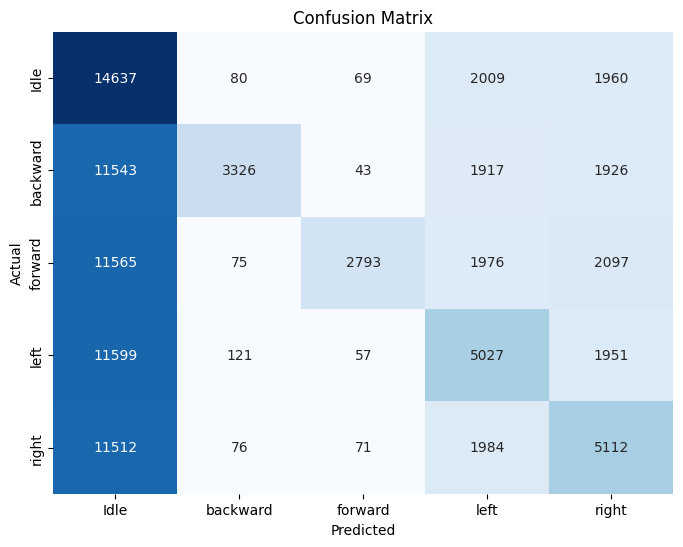

In [1812]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


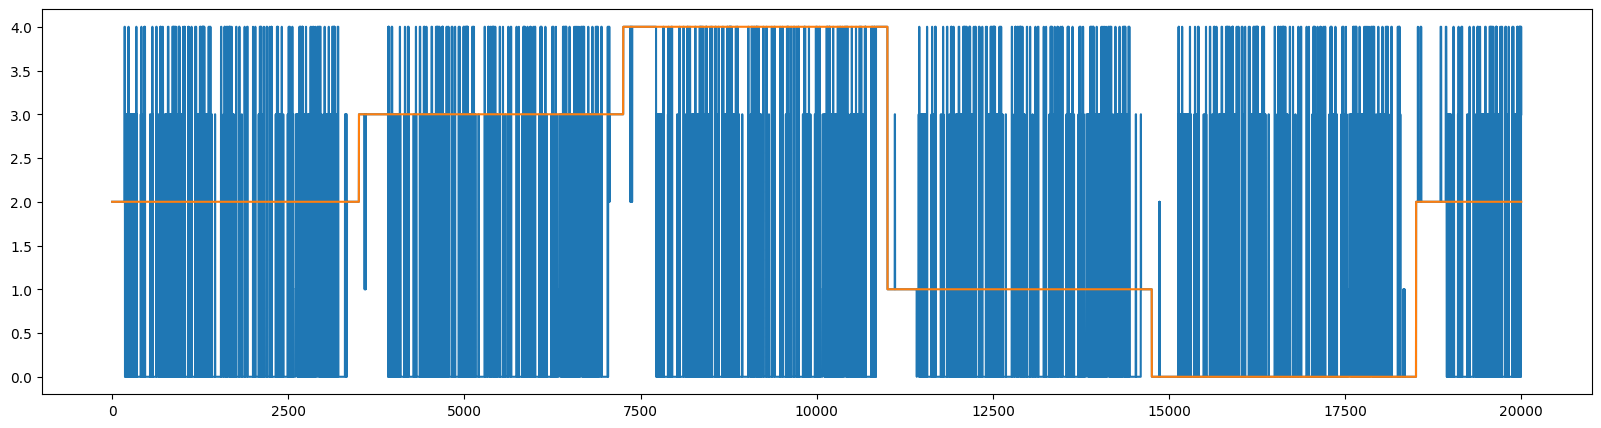

In [1813]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(reversed_array[:20000])
plt.plot(y_encoded[len(y) - len(y_pred):20000 + len(y) - len(y_pred)])
plt.show()

In [1814]:
predicted_labels

array(['forward', 'forward', 'forward', ..., 'Idle', 'Idle', 'Idle'],
      dtype=object)

In [1815]:
unique, counts = np.unique(y_encoded, return_counts=True)
print(dict(zip(unique, counts)))


{0: 18755, 1: 18755, 2: 18755, 3: 18755, 4: 18755}
